In [1]:
import lime
import numpy as np
import pandas as pd
import seaborn as sns
import lime.lime_tabular
from sklearn import tree
from dtreeviz.trees import *
import pandas_profiling as pp
import matplotlib.pyplot as plt
from featexp import get_trend_stats
from sklearn.metrics import f1_score
from featexp import get_univariate_plots
from statannot import add_stat_annotation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display_svg
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
bank_data=pd.read_csv('bank-additional-full.csv',sep=';')
#bank_data.drop(columns=["duration", "euribor3m", "nr.employed", "emp.var.rate", "cons.price.idx", "cons.conf.idx"], inplace=True)
bank_data.drop(columns=["euribor3m", "nr.employed"], inplace=True)
bank_data['y'] = pd.Categorical(bank_data['y'], ["yes","no"])
#bank_data['marital'] = pd.Categorical(bank_data['marital'], ["married","single","divorced","unknown"])
#bank_data['housing'] = pd.Categorical(bank_data['housing'], ["yes", "no", "unknown"])
#bank_data['loan'] = pd.Categorical(bank_data['loan'], ["yes", "no", "unknown"])
#bank_data['month'] = pd.Categorical(bank_data['month'], ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])
#bank_data['day_of_week'] = pd.Categorical(bank_data['month'], bank_data.day_of_week.unique())

bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
y                 41188 non-null category
dtypes: category(1), float64(3), int64(5), object(10)
memory usage: 5.7+ MB


# What to Predict

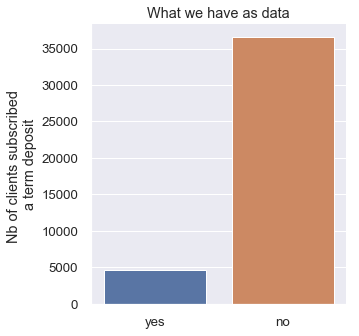

In [3]:
y_value_counts = pd.DataFrame({"index":bank_data.y.value_counts().index, "y":bank_data.y.value_counts()})
sns.set(font_scale = 1.2)
g = sns.catplot(x="index", y="y", kind="bar", data=y_value_counts)
g.set(title="What we have as data", xlabel="", ylabel="Nb of clients subscribed \na term deposit")

# Visualization of data

In [4]:
bank_data_type_int = bank_data.select_dtypes(include=['int64', 'float64'])
bank_data_type_int["y"] = bank_data["y"].values
bank_data_type_int = bank_data_type_int.melt("y")

/home/shivalika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
bank_data_type_int.variable.unique()

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx'], dtype=object)

In [6]:
def plot_int(variable, df, ylim_max):
    x = "y"
    y = "value"
    order = ['yes', 'no']
    ax = sns.violinplot(data=df[df["variable"]==variable], x=x, y=y, order=order)
    ax.set_ylabel(variable)
    ax.set_xlabel("Deposit value counts")
    ax.set(ylim=(0, ylim_max))
    add_stat_annotation(ax, data=df[df["variable"]==variable], x=x, y=y, order=order,
                    box_pairs=[("yes", "no")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes v.s. no: Mann-Whitney-Wilcoxon test two-sided P_val=1.608e-02 U_stat=8.296e+07


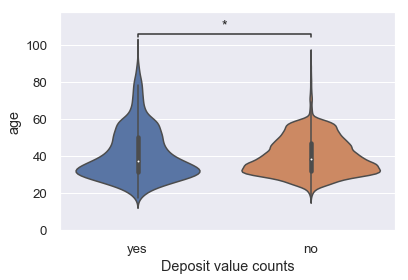

In [7]:
plot_int("age", bank_data_type_int, 100)

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes v.s. no: Mann-Whitney-Wilcoxon test two-sided P_val=3.419e-38 U_stat=7.543e+07


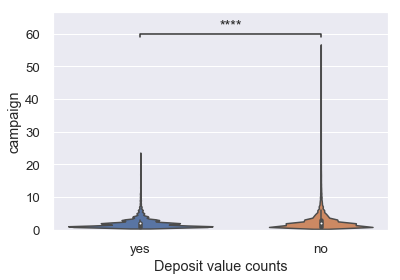

In [8]:
plot_int("campaign", bank_data_type_int, 50)

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes v.s. no: Mann-Whitney-Wilcoxon test two-sided P_val=0.000e+00 U_stat=1.033e+08


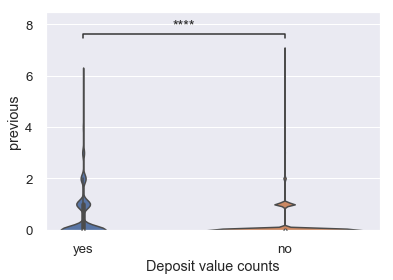

In [9]:
plot_int("previous", bank_data_type_int, 8)

In [10]:
bank_data_type_obj = bank_data.select_dtypes(exclude=['int64', 'float64'])
bank_data_type_obj["y"] = bank_data["y"].values

/home/shivalika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
bank_data_type_obj.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [12]:
def plot_obj(variable, df, order=None):
    df = pd.DataFrame(pd.crosstab(df["y"], df[variable]).reset_index()).melt("y")
    hue = variable
    if order != None:
        df[variable] = pd.Categorical(df[variable], order)
    ax = sns.catplot(data=df, x="value", y=variable, hue="y", kind="bar", height=5, col="y", col_wrap=2)
    plt.xticks(rotation=90)
    ax.set( xlabel="Deposit value counts")

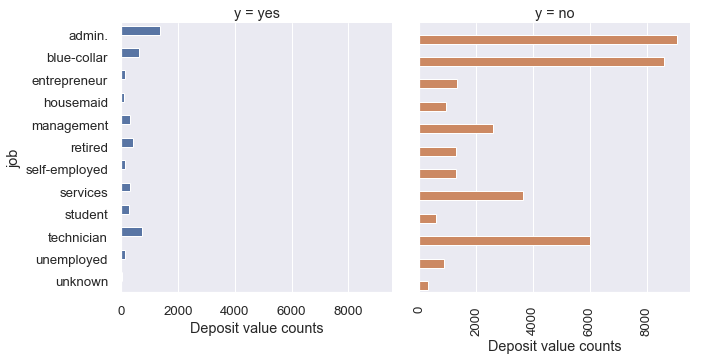

In [13]:
plot_obj("job", bank_data_type_obj, None)

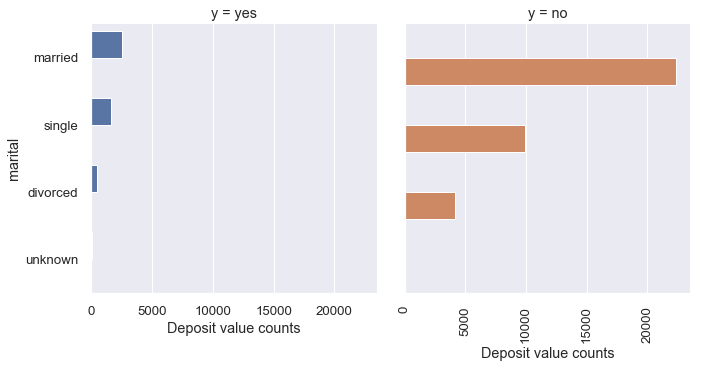

In [14]:
plot_obj("marital", bank_data_type_obj, ["married","single","divorced","unknown"])

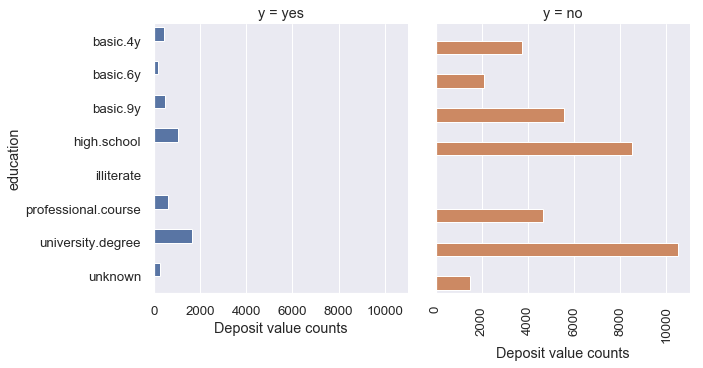

In [15]:
plot_obj("education", bank_data_type_obj, None)

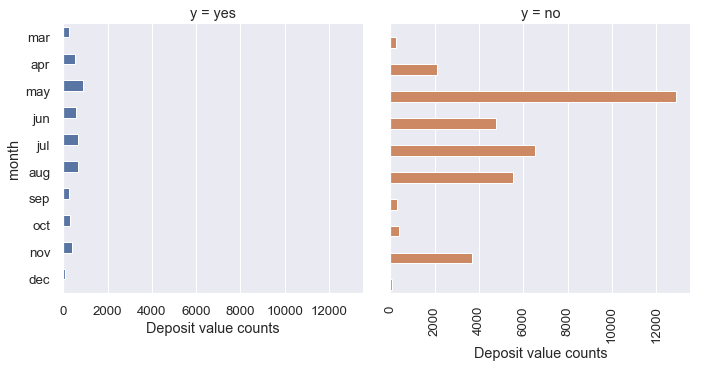

In [16]:
plot_obj("month", bank_data_type_obj, ["mar","apr","may","jun","jul","aug","sep","oct","nov","dec"])

# Cleaning - get dummies

In [17]:
y = bank_data.pop("y")
lab = LabelEncoder()
lab.fit(y)
y_label = lab.transform(y)

In [18]:
bank_data_dummies = pd.get_dummies(bank_data)

In [19]:
bank_data_dummies.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_wee

# Correlation

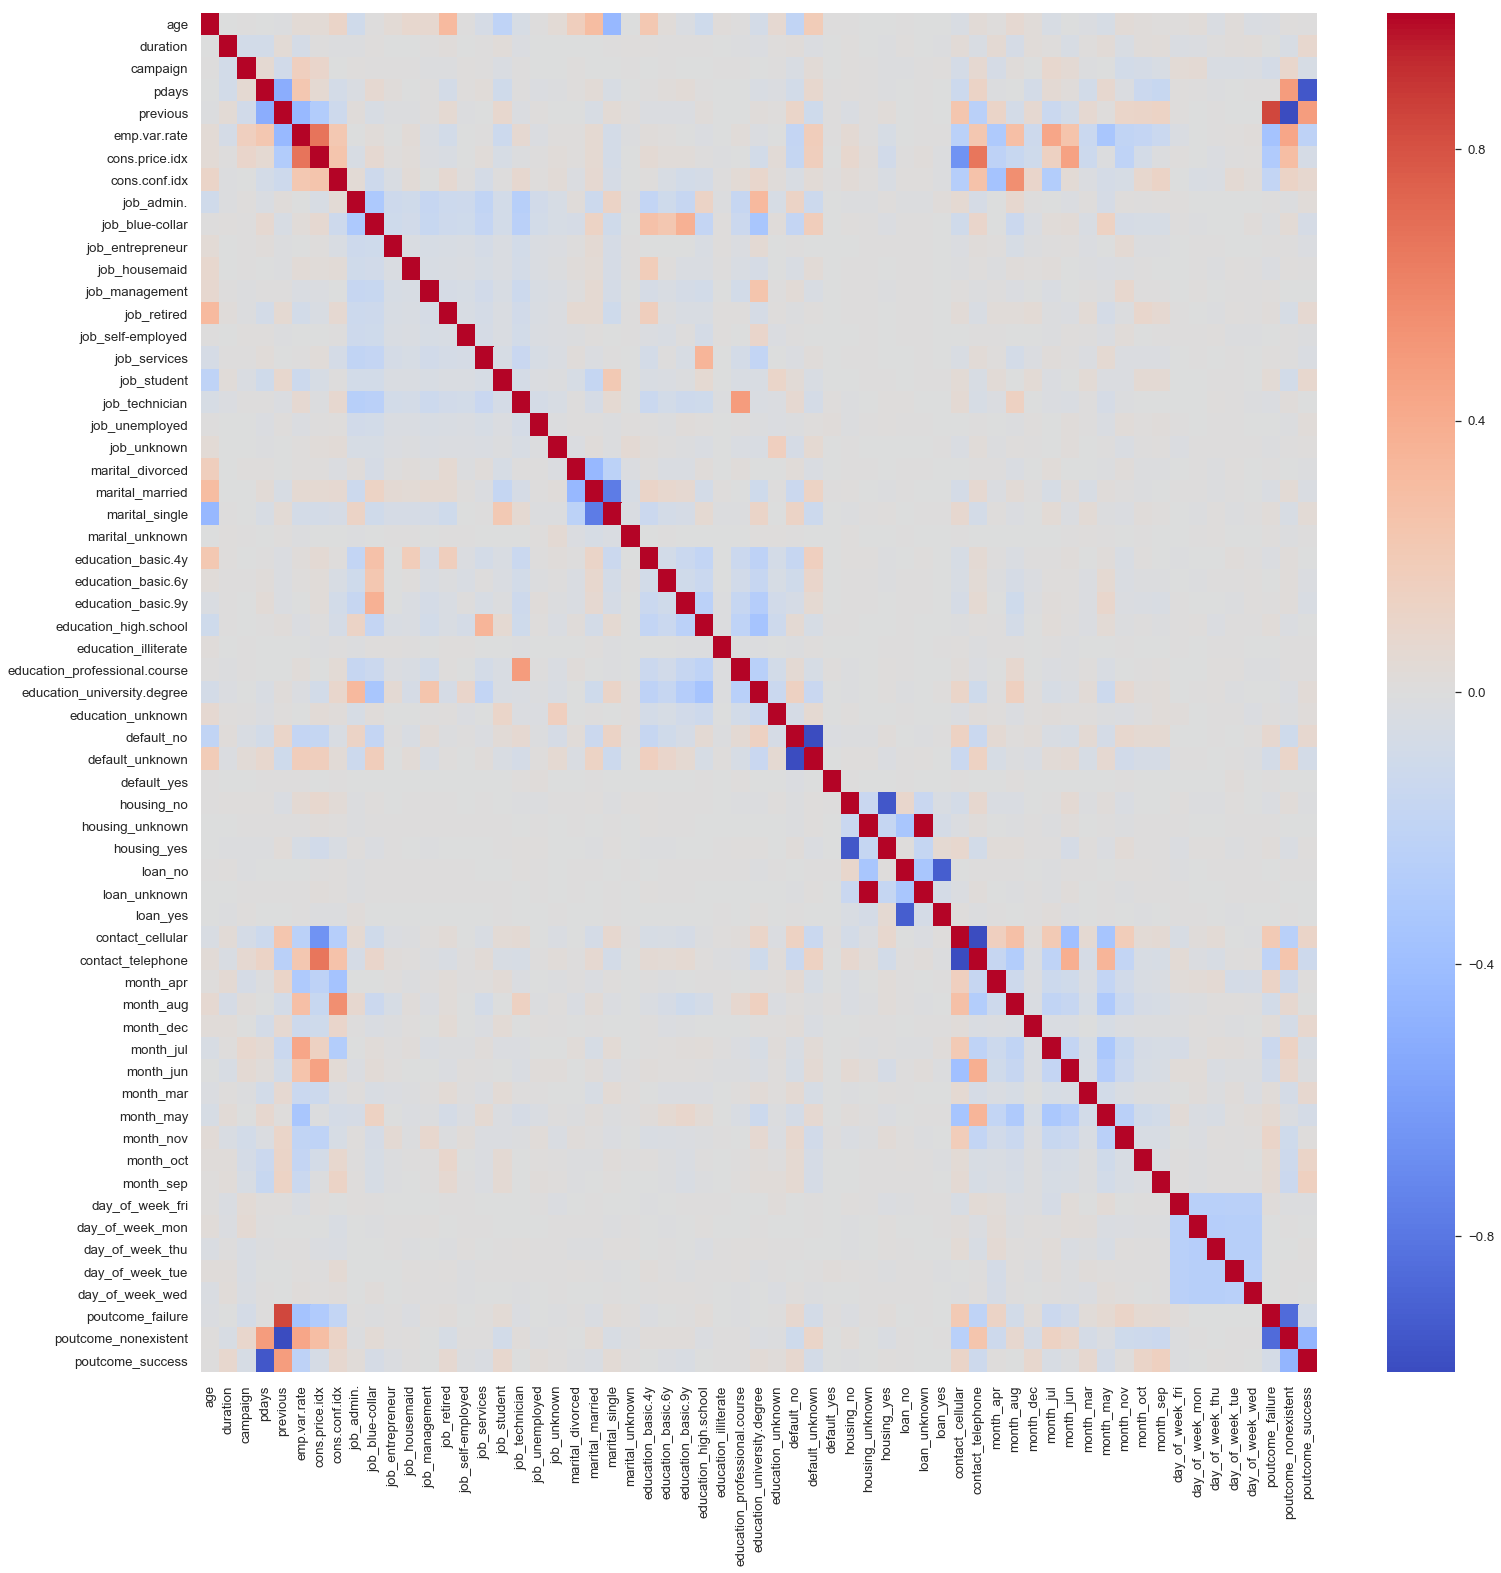

In [56]:
fig=plt.figure(figsize = (25,25))
sns.set(font_scale = 1.2)
sns.heatmap(bank_data_dummies.corr(method='spearman'), annot=False, cmap='coolwarm')
fig.savefig('test.png')

# Train and Test Split using SMOTE
Researchers have found that balancing the data will to better classification models. We will try balancing our data using SMOTE.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(bank_data_dummies, y_label, test_size = 0.33, 
                                                    random_state = 2, shuffle = True, stratify = y_label)

In [22]:
X_train.shape

(27595, 61)

In [23]:
X_test.shape

(13593, 61)

# Feature exploration for supervised learning

featexp bins a feature into equal population bins and shows mean value of dependent variable (target) in each bin. Here's how to read these plots:

Trend plot on left helps you understand the relationship between target and feature.
Population distribution helps you make sure the feature is correct.
Also, shows number of trend direction changes and correlation between train and test trend which can be used to identify noisy features. High number of trend changes or low trend correlation implies high noise.


In [24]:
data_train = X_train.copy()
data_train["target"] = y_train
data_test = X_test.copy()
data_test["target"] = y_test

                                            Plots for age                                             
                                           Train data plots                                           


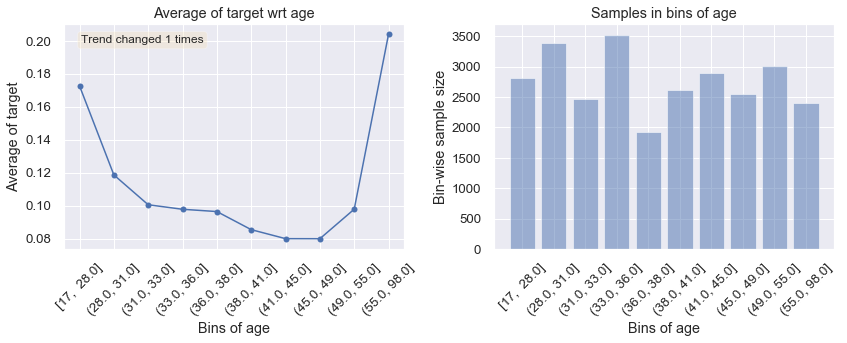

                                           Test data plots                                            


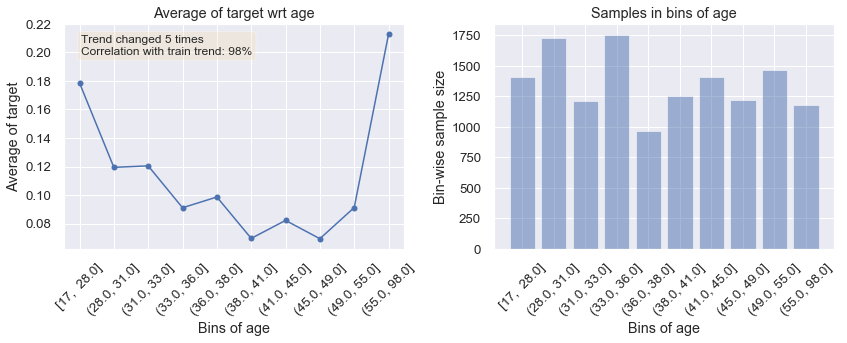

--------------------------------------------------------------------------------------------------------------




In [25]:
get_univariate_plots(data=data_train, target_col='target', data_test=data_test, features_list=['age'])

In [26]:
stats = get_trend_stats(data=data_train, target_col='target', data_test=data_test)
stats

Only one bin created for pdays. Correlation can't be calculated
Returning stats for all numeric features


Feature  Trend_changes  Trend_changes_test  \
0                             age              1                   5   
1                        duration              0                   0   
2                        campaign              0                   0   
3                           pdays              0                   0   
4                        previous              0                   0   
5                    emp.var.rate              3                   3   
6                  cons.price.idx              3                   3   
7                   cons.conf.idx              3                   3   
8                      job_admin.              0                   0   
9                 job_blue-collar              0                   0   
10               job_entrepreneur              0                   0   
11                  job_housemaid              0                   0   
12                 job_management              0                   0   
13                    job_retired              0                   0   
14              job_self-employed              0                   0   
15                   job_services              0                   0   
16                    job_student              0                   0   
17                 job_technician              0                   0   
18                 job_unemployed              0                   0   
19                    job_unknown              0                   0   
20               marital_divorced              0                   0   
21                marital_married              0                   0   
22                 marital_single              0                   0   
23                marital_unknown              0                   0   
24             education_basic.4y              0                   0   
25             education_basic.6y              0                   0   
26             education_basic.9y              0                   0   
27          education_high.school              0                   0   
28           education_illiterate              0                   0   
29  education_professional.course              0                   0   
..                            ...            ...                 ...   
31              education_unknown              0                   0   
32                     default_no              0                   0   
33                default_unknown              0                   0   
34                    default_yes              0                   0   
35                     housing_no              0                   0   
36                housing_unknown              0                   0   
37                    housing_yes              0                   0   
38                        loan_no              0                   0   
39                   loan_unknown              0                   0   
40                       loan_yes              0                   0   
41               contact_cellular              0                   0   
42              contact_telephone              0                   0   
43                      month_apr              0                   0   
44                      month_aug              0                   0   
45                      month_dec              0                   0   
46                      month_jul              0                   0   
47                      month_jun              0                   0   
48                      month_mar              0                   0   
49                      month_may              0                   0   
50                      month_nov              0                   0   
51                      month_oct              0                   0   
52                      month_sep              0                   0   
53                day_of_week_fri              0                   0   
54                day_of_week_mon              0                  

# Imbalance Data - UnderSampling & OverSampling Approaches

/home/shivalika/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


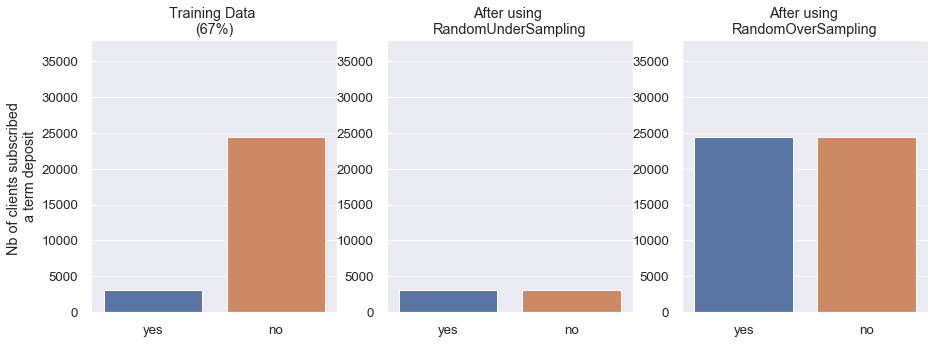

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

p = pd.DataFrame(y_train)[0]
y_value_counts = pd.DataFrame({"index":p.value_counts().index, "y":p.value_counts()})
y_value_counts["index"] = lab.inverse_transform(y_value_counts["index"].tolist())
ax0 = sns.barplot(x="index", y="y", data=y_value_counts, ax=ax[0], order=["yes", "no"])
ax0.set(title="Training Data \n(67%)", ylim=(0,38000) ,xlabel="", ylabel="Nb of clients subscribed \na term deposit")


X_train_undersample, y_train_undersample = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train.ravel())
X_train_undersample = pd.DataFrame(X_train_undersample, columns=bank_data_dummies.columns)
p = pd.DataFrame(y_train_undersample)[0]
y_value_counts = pd.DataFrame({"index":p.value_counts().index, "y":p.value_counts()})
y_value_counts["index"] = lab.inverse_transform(y_value_counts["index"].tolist())
ax1 = sns.barplot(x="index", y="y", data=y_value_counts, ax=ax[1])
ax1.set(title="After using \nRandomUnderSampling", ylim=(0,38000) ,xlabel="", ylabel="")


X_train_oversample, y_train_oversample = RandomOverSampler(random_state=0).fit_sample(X_train, y_train.ravel())
X_train_oversample = pd.DataFrame(X_train_oversample, columns=bank_data_dummies.columns)
p = pd.DataFrame(y_train_oversample)[0]
y_value_counts = pd.DataFrame({"index":p.value_counts().index, "y":p.value_counts()})
y_value_counts["index"] = lab.inverse_transform(y_value_counts["index"].tolist())
ax2 = sns.barplot(x="index", y="y",  data=y_value_counts, ax=ax[2])
ax2.set(title="After using \nRandomOverSampling", ylim=(0,38000) ,xlabel="", ylabel="")

fig.show()

# Machine learning

In [28]:
def merge_str(x, y):
    return str(x)+" - "+str(y)

def gridsearchcv_results(gs, algo):
    df = pd.DataFrame(gs.cv_results_)
    df["Algorithm"] = algo
    df = df[["params", "mean_test_score", "std_test_score", "rank_test_score", "mean_train_score", "std_train_score", "Algorithm", "split0_test_score", "split1_test_score", "split2_test_score", 
               "split0_train_score", "split1_train_score", "split2_train_score"]]
    df.columns = ["params", "mean_validation_score", "std_validation_score", "rank_validation_score", "mean_train_score", "std_train_score", "Algorithm", "split0_validation_score", "split1_validation_score", "split2_validation_score", 
               "split0_train_score", "split1_train_score", "split2_train_score"]
    df["Algorithm_params"] = df.apply(lambda x: merge_str(x["Algorithm"], x["params"]), axis=1)
    df.drop(columns=["Algorithm", "params"],inplace=True)
    return df
    
def run_gridsearch(train, target, metrics):

    lgr = LogisticRegression()
    dst = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    
    params_lgr = { 'C': [0.001,0.01,0.1,1] }
    params_dst = { 'max_depth':[2,3,4,5,7,10,25,50] }
    params_rfc = { 'n_estimators': [50,100,200,300] }

    cv = StratifiedKFold(n_splits=3)
    lg = GridSearchCV(estimator=lgr,param_grid=params_lgr,scoring=metrics,cv=cv, n_jobs=-1, verbose=10, return_train_score=True).fit(train,target)
    dc = GridSearchCV(estimator=dst,param_grid=params_dst,scoring=metrics,cv=cv, n_jobs=-1, verbose=10, return_train_score=True).fit(train,target)
    rf = GridSearchCV(estimator=rfc,param_grid=params_rfc,scoring=metrics,cv=cv, n_jobs=-1, verbose=10, return_train_score=True).fit(train,target)
    
    lg_cv = gridsearchcv_results(lg, "LogisticRegression")
    dc_cv = gridsearchcv_results(dc, "DecisionTreeClassifier")
    rf_cv = gridsearchcv_results(rf, "RandomForestClassifier")
    cv = pd.concat([lg_cv, dc_cv, rf_cv])
    cv = cv[cv["rank_validation_score"]==1]
    
    return [cv, lg.best_estimator_ , dc.best_estimator_ , rf.best_estimator_ ]

In [29]:
[cv, lg, dc, rf] = run_gridsearch(X_train, y_train,"f1") 
[cv_undersampling, lg_undersampling, dc_undersampling, rf_undersampling] = run_gridsearch(X_train_undersample, y_train_undersample,"accuracy") 
[cv_oversampling, lg_oversampling, dc_oversampling, rf_oversampling] = run_gridsearch(X_train_oversample, y_train_oversample,"accuracy") 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    3.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.0s finished
/home/shivalika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1035s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.1s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   12.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   16.6s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   23.9s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0613s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s finished
/home/shivalika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0233s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   5 out of  24 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of  24 | elapsed:    0.1s remaini

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    3.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.8s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.7s finished
/home/shivalika/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1781s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:    1.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.2s finished


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   18.1s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   24.6s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   36.0s finished


In [30]:
def parse_res(df):
    df = df[["split0_validation_score", "split1_validation_score", "split2_validation_score","split0_train_score", "split1_train_score", "split2_train_score", "Algorithm_params"]]
    df.columns = ["Fold1_validation", "Fold2_validation", "Fold3_validation", "Fold1_train", "Fold2_train", "Fold3_train", "Algorithm_params"]
    df = df.melt("Algorithm_params")   
    df["Fold"] = df["variable"].apply(lambda x : x.split("_")[0])
    df["Dataset"] = df["variable"].apply(lambda x : x.split("_")[1])  
    df.drop(columns=["variable"], inplace=True)
    return df    

cv_melt = parse_res(cv)
cv_undersampling_melt = parse_res(cv_undersampling)
cv_oversampling_melt = parse_res(cv_oversampling)

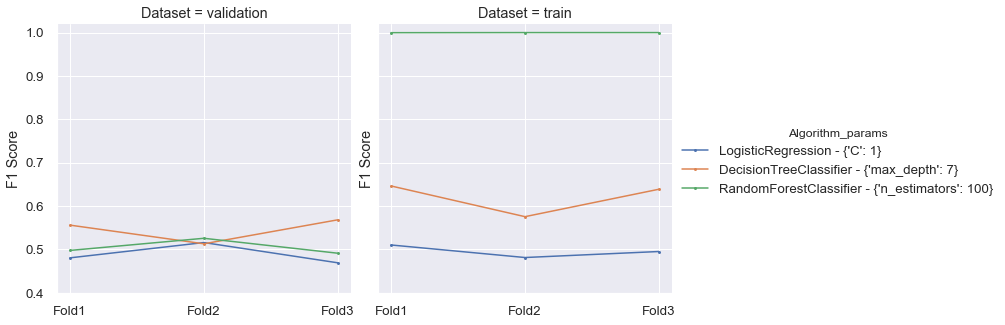

In [31]:
sns.set(font_scale = 1.2)
g = sns.FacetGrid(cv_melt, col="Dataset", hue="Algorithm_params", col_wrap=2, height=5)
g = g.map(plt.plot, "Fold", "value", marker=".").add_legend()
g.set(ylabel="F1 Score", xlabel="", ylim=(0.4,1.02))

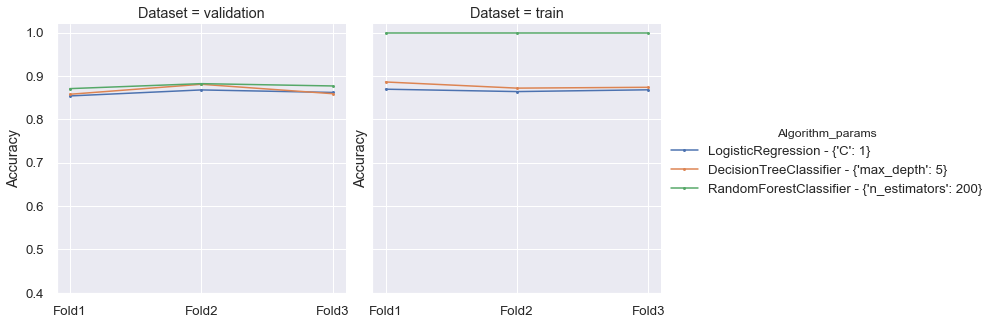

In [32]:
sns.set(font_scale = 1.2)
g = sns.FacetGrid(cv_undersampling_melt, col="Dataset", hue="Algorithm_params", col_wrap=2, height=5)
g = g.map(plt.plot, "Fold", "value", marker=".").add_legend()
g.set(ylabel="Accuracy", xlabel="", ylim=(0.4,1.02))

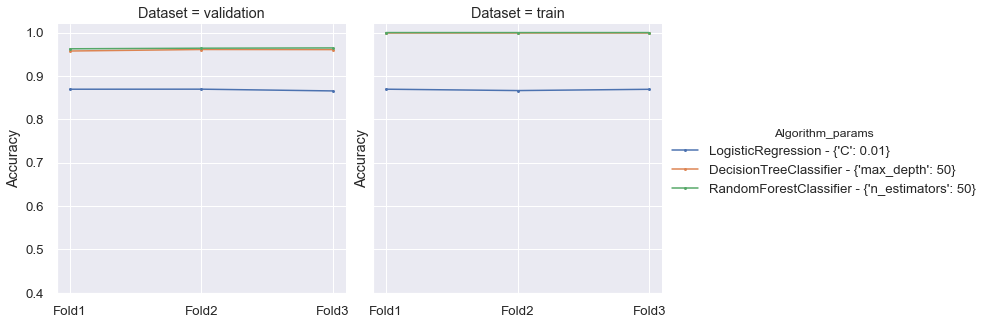

In [33]:
sns.set(font_scale = 1.2)
g = sns.FacetGrid(cv_oversampling_melt, col="Dataset", hue="Algorithm_params", col_wrap=2, height=5)
g = g.map(plt.plot, "Fold", "value", marker=".").add_legend()
g.set(ylabel="Accuracy", xlabel="", ylim=(0.4,1.02))

In [34]:
initial_data_metric_f1 = cv[[ "Algorithm_params", "mean_train_score", "mean_validation_score", "rank_validation_score"]].copy()

lg_test = accuracy_score(lg.predict(X_train), y_train)
dc_test = accuracy_score(dc.predict(X_train), y_train)
rf_test = accuracy_score(rf.predict(X_train), y_train)
initial_data_metric_f1["X_train_accuracy_score"] = [lg_test,dc_test,rf_test]

lg_test = accuracy_score(lg.predict(X_test), y_test)
dc_test = accuracy_score(dc.predict(X_test), y_test)
rf_test = accuracy_score(rf.predict(X_test), y_test)
initial_data_metric_f1["X_test_accuracy_score"] = [lg_test,dc_test,rf_test]

In [35]:
undersample_data_metric_accuracy = cv_undersampling[[ "Algorithm_params", "mean_train_score", "mean_validation_score", "rank_validation_score"]].copy()

lg_test = accuracy_score(lg_undersampling.predict(X_train), y_train)
dc_test = accuracy_score(dc_undersampling.predict(X_train), y_train)
rf_test = accuracy_score(rf_undersampling.predict(X_train), y_train)
undersample_data_metric_accuracy["X_train_accuracy_score"] = [lg_test,dc_test,rf_test]

lg_test = accuracy_score(lg_undersampling.predict(X_test), y_test)
dc_test = accuracy_score(dc_undersampling.predict(X_test), y_test)
rf_test = accuracy_score(rf_undersampling.predict(X_test), y_test)
undersample_data_metric_accuracy["X_test_accuracy_score"] = [lg_test,dc_test,rf_test]


In [36]:
oversample_data_metric_accuracy = cv_oversampling[[ "Algorithm_params", "mean_train_score", "mean_validation_score", "rank_validation_score"]].copy()

lg_test = accuracy_score(lg_oversampling.predict(X_train), y_train)
dc_test = accuracy_score(dc_oversampling.predict(X_train), y_train)
rf_test = accuracy_score(rf_oversampling.predict(X_train), y_train)
oversample_data_metric_accuracy["X_train_accuracy_score"] = [lg_test,dc_test,rf_test]

lg_test = accuracy_score(lg_oversampling.predict(X_test), y_test)
dc_test = accuracy_score(dc_oversampling.predict(X_test), y_test)
rf_test = accuracy_score(rf_oversampling.predict(X_test), y_test)
oversample_data_metric_accuracy["X_test_accuracy_score"] = [lg_test,dc_test,rf_test]

In [37]:
benchmark_data_approaches = pd.DataFrame({"Data":["Imbalanced", "Imbalanced", "Imbalanced", "UnderSampling", "UnderSampling", "UnderSampling", "OverSampling", "OverSampling", "OverSampling"]})
benchmark_data_approaches["Metrics (Optimization)"] = ["F1 score", "F1 score", "F1 score", "Accuracy", "Accuracy", "Accuracy", "Accuracy", "Accuracy", "Accuracy"]
benchmark_data_approaches["Best estimation params"] = initial_data_metric_f1["Algorithm_params"].tolist()+undersample_data_metric_accuracy["Algorithm_params"].tolist()+oversample_data_metric_accuracy["Algorithm_params"].tolist()
benchmark_data_approaches["X_train_accuracy_score"] = initial_data_metric_f1["X_train_accuracy_score"].tolist()+undersample_data_metric_accuracy["X_train_accuracy_score"].tolist()+oversample_data_metric_accuracy["X_train_accuracy_score"].tolist()
benchmark_data_approaches["X_test_accuracy_score"] = initial_data_metric_f1["X_test_accuracy_score"].tolist()+undersample_data_metric_accuracy["X_test_accuracy_score"].tolist()+oversample_data_metric_accuracy["X_test_accuracy_score"].tolist()
benchmark_data_approaches["Algo"] = benchmark_data_approaches["Best estimation params"].apply(lambda x : x.split("-")[0])
benchmark_data_approaches["Best estimation params"] = benchmark_data_approaches["Best estimation params"].apply(lambda x : x.split("-")[1])

benchmark_data_approaches = benchmark_data_approaches[['Data', 'Metrics (Optimization)', 'Algo', 'Best estimation params',
       'X_train_accuracy_score', 'X_test_accuracy_score']]

benchmark_data_approaches

Data Metrics (Optimization)                     Algo  \
0     Imbalanced               F1 score      LogisticRegression    
1     Imbalanced               F1 score  DecisionTreeClassifier    
2     Imbalanced               F1 score  RandomForestClassifier    
3  UnderSampling               Accuracy      LogisticRegression    
4  UnderSampling               Accuracy  DecisionTreeClassifier    
5  UnderSampling               Accuracy  RandomForestClassifier    
6   OverSampling               Accuracy      LogisticRegression    
7   OverSampling               Accuracy  DecisionTreeClassifier    
8   OverSampling               Accuracy  RandomForestClassifier    

   Best estimation params  X_train_accuracy_score  X_test_accuracy_score  
0                {'C': 1}                0.907266               0.908188  
1        {'max_depth': 7}                0.920819               0.912381  
2   {'n_estimators': 100}                0.999964               0.912602  
3                {'C': 1}                0.857655               0.864416  
4        {'max_depth': 5}                0.799746               0.806371  
5   {'n_estimators': 200}                0.874506               0.853086  
6             {'C': 0.01}                0.857329               0.862135  
7       {'max_depth': 50}                1.000000               0.892077  
8    {'n_estimators': 50}                1.000000               0.908409

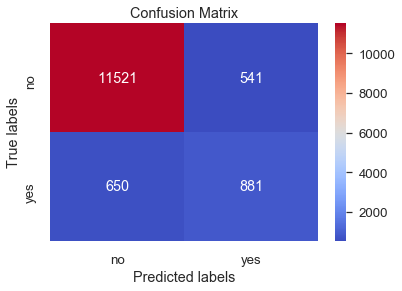

In [38]:
conf_mat = confusion_matrix(y_test, dc.predict(X_test))

ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, ax=ax, fmt='d', cmap='coolwarm')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no', 'yes'])
ax.yaxis.set_ticklabels(['no', 'yes'])
plt.show()

# Looking for feature importances

In [39]:
cv = StratifiedKFold(n_splits=10)

fI = []
folds = []
n = 0
for train, test in cv.split(X_train, y_train):
    n += 1
    dc.fit(X_train.iloc[train], y_train[train])
    fI.append(dc.feature_importances_.tolist())
    folds += [n]*len(dc.feature_importances_)
    
fI = [y for x in fI for y in x]
fI = pd.DataFrame({"Feature_Importances":fI, "Variables": X_train.columns.tolist()*10, "Fold":folds})

fI_top15_variables = fI.groupby(["Variables"])["Feature_Importances"].max().reset_index().sort_values("Feature_Importances", ascending=False)["Variables"].tolist()[:15]
fI_top15 = fI[fI["Variables"].isin(fI_top15_variables)].sort_values(['Feature_Importances', "Variables"], ascending=[False, True])
fI_top15.head(15)

Feature_Importances Variables  Fold
367             0.483391  duration     7
306             0.481863  duration     6
1               0.480615  duration     1
428             0.480172  duration     8
123             0.479979  duration     3
184             0.478618  duration     4
550             0.475594  duration    10
245             0.474017  duration     5
62              0.472534  duration     2
489             0.470831  duration     9
64              0.226067     pdays     2
491             0.224425     pdays     9
430             0.223323     pdays     8
552             0.222070     pdays    10
308             0.217489     pdays     6

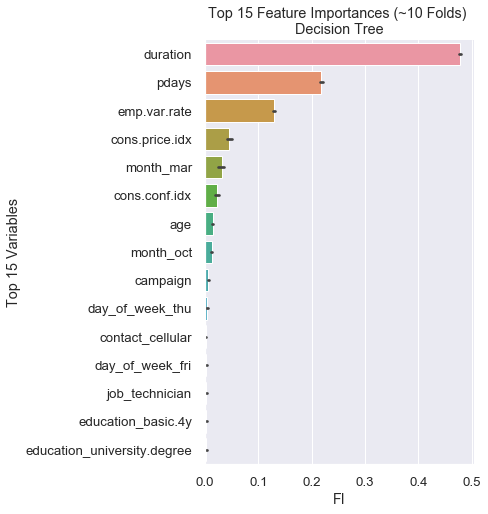

In [40]:
g = sns.catplot(data=fI_top15, y="Variables", x="Feature_Importances", height=7, kind="bar", order=fI_top15_variables)
g.set(title="Top 15 Feature Importances (~10 Folds) \nDecision Tree", xlabel="FI", ylabel="Top 15 Variables")

# Visualization of best estimator (decision tree) in a shape of tree

In [41]:
viz = dtreeviz(dc, 
               X_train_undersample, 
               y_train,
               target_name='y',
               feature_names=X_train.columns,
               class_names=["yes", "no"]
              )  
              
viz

In [58]:

viz = dtreeviz(dc, 
               X_train, 
               y_train,
               target_name='y',
               feature_names=X_train.columns,
               class_names=["yes", "no"],
               fancy=False
              )  
viz.view()

# Interpretability

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.as_matrix(), mode="classification",
                                                   feature_names=X_train.columns.tolist())

/home/shivalika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [44]:
X_test.iloc[2]

age                               28.000
duration                         957.000
campaign                           1.000
pdays                              6.000
previous                           1.000
emp.var.rate                      -1.700
cons.price.idx                    94.215
cons.conf.idx                    -40.300
job_admin.                         0.000
job_blue-collar                    0.000
job_entrepreneur                   0.000
job_housemaid                      0.000
job_management                     0.000
job_retired                        0.000
job_self-employed                  0.000
job_services                       1.000
job_student                        0.000
job_technician                     0.000
job_unemployed                     0.000
job_unknown                        0.000
marital_divorced                   0.000
marital_married                    0.000
marital_single                     1.000
marital_unknown                    0.000
education_basic.

In [45]:
exp = explainer.explain_instance(X_test.iloc[2], dc.predict_proba, num_features=6, top_labels=2)
exp.show_in_notebook()

In [47]:
X_test.iloc[3]

age                               31.000
duration                          90.000
campaign                           1.000
pdays                            999.000
previous                           0.000
emp.var.rate                      -1.800
cons.price.idx                    92.893
cons.conf.idx                    -46.200
job_admin.                         0.000
job_blue-collar                    0.000
job_entrepreneur                   0.000
job_housemaid                      0.000
job_management                     1.000
job_retired                        0.000
job_self-employed                  0.000
job_services                       0.000
job_student                        0.000
job_technician                     0.000
job_unemployed                     0.000
job_unknown                        0.000
marital_divorced                   0.000
marital_married                    0.000
marital_single                     1.000
marital_unknown                    0.000
education_basic.

In [46]:
exp = explainer.explain_instance(X_test.iloc[3], dc.predict_proba, num_features=6, top_labels=2)
exp.show_in_notebook()